In [42]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import shap
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV

Import house price dataset for training and evaluation

In [43]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [44]:
df_train.info

<bound method DataFrame.info of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Ut

Only keep numeric values from the dataset

In [45]:
X_train = df_train.select_dtypes(include=np.number).copy()
X_train = X_train.drop(['SalePrice'], axis=1)
y_train = pd.DataFrame(df_train["SalePrice"])
X_test = df_test.select_dtypes(include=np.number).copy()

In [46]:
X_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,548,0,61,0,0,0,0,0,2,2008
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,460,298,0,0,0,0,0,0,5,2007
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,608,0,42,0,0,0,0,0,9,2008
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,642,0,35,272,0,0,0,0,2,2006
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,836,192,84,0,0,0,0,0,12,2008


Feature engineering 

In [47]:
for df in (X_train, X_test):
    df["n_bathrooms"] = df["BsmtFullBath"] + (df["BsmtHalfBath"] * 0.5) + df["FullBath"] + (df["HalfBath"] * 0.5)
    df["area_with_basement"] = df["GrLivArea"] + df["TotalBsmtSF"]

Define xgboost regressor

In [48]:
model = xgb.XGBRegressor(eval_metric='rmsle')

# set up our search grid
parameters = {"max_depth": [3, 4, 5, 6],
              "n_estimators": [100, 200, 300, 400, 500, 600, 700],
              "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05]}

# try out every combination of the above values
search = GridSearchCV(model, parameters, cv=5).fit(X_train, y_train)
model = xgb.XGBRegressor(learning_rate=search.best_params_["learning_rate"],
                             n_estimators=search.best_params_["n_estimators"],
                             max_depth=search.best_params_["max_depth"],
                             eval_metric='rmsle')

Training xgboost regressor

In [49]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Calculate mean squared log error

In [50]:
solution = pd.read_csv('solution.csv')
y_true = solution["SalePrice"]

predictions = model.predict(X_test)

RMSLE = np.sqrt(mean_squared_log_error(y_true, predictions))
print("The RMSLE is %.4f" % RMSLE)

The RMSLE is 0.1417


Calculate SHAP values with python package shap

In [51]:
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

shap_values

PermutationExplainer explainer: 1460it [00:46, 24.61it/s]                      


.values =
array([[     0.        ,     94.21494141,   1281.92728516, ...,
          -494.60343424,  -6857.20910807, -18225.78982747],
       [     0.        ,     46.29548828,   1815.06317057, ...,
          -520.29541992,  -3005.59077474,    446.4122819 ],
       [     0.        ,    322.03597982,    886.01034505, ...,
          -583.65830078,   2637.64177409,    604.3010612 ],
       ...,
       [     0.        ,   -256.13395833,   -348.74172201, ...,
           317.93179688,  -3109.06673177,  -7922.03057943],
       [     0.        ,   1005.83739583,    453.84557943, ...,
           242.89087891,  -3987.04953451, -18154.27083659],
       [     0.        ,    103.36758138,    699.6467806 , ...,
           411.71182292,   3562.33170573,  13132.32798828]])

.base_values =
array([172580.0340625, 172580.0340625, 172580.0340625, ...,
       172580.0340625, 172580.0340625, 172580.0340625])

.data =
array([[1.461e+03, 2.000e+01, 8.000e+01, ..., 2.010e+03, 1.000e+00,
        1.778e+03],
    

Plots for shap values 

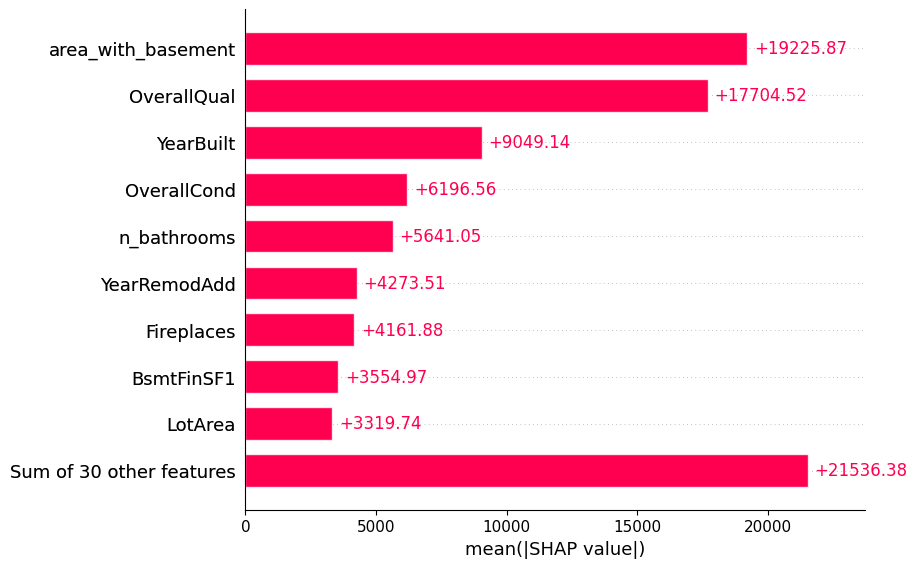

In [52]:
# bar plot
shap.plots.bar(shap_values)

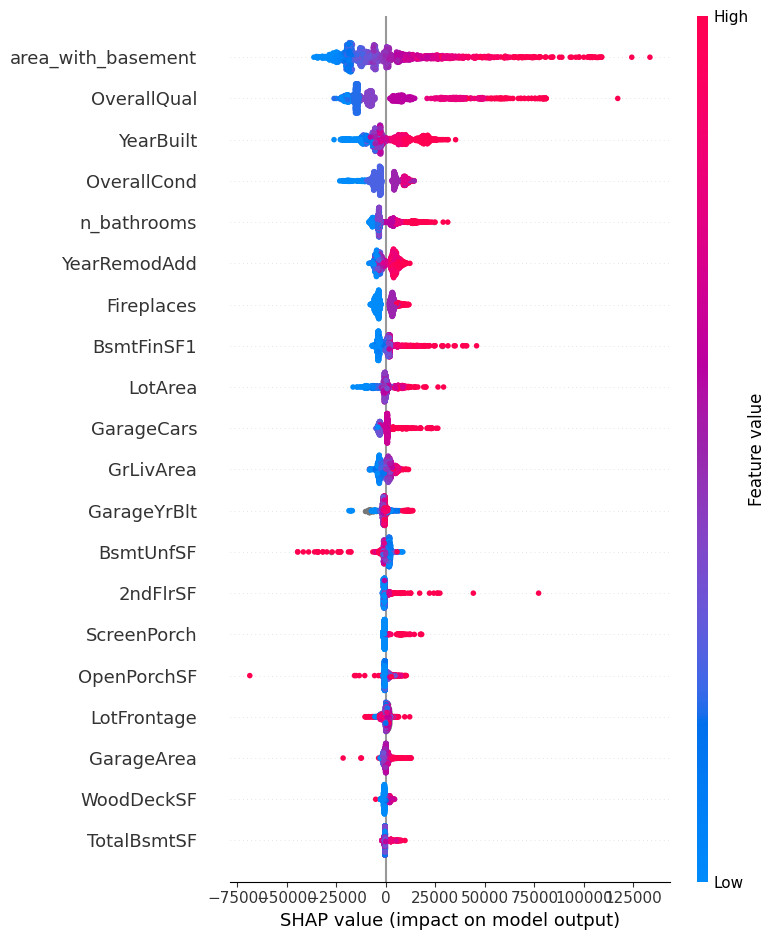

In [53]:
# beeswarm plot
shap.summary_plot(shap_values)

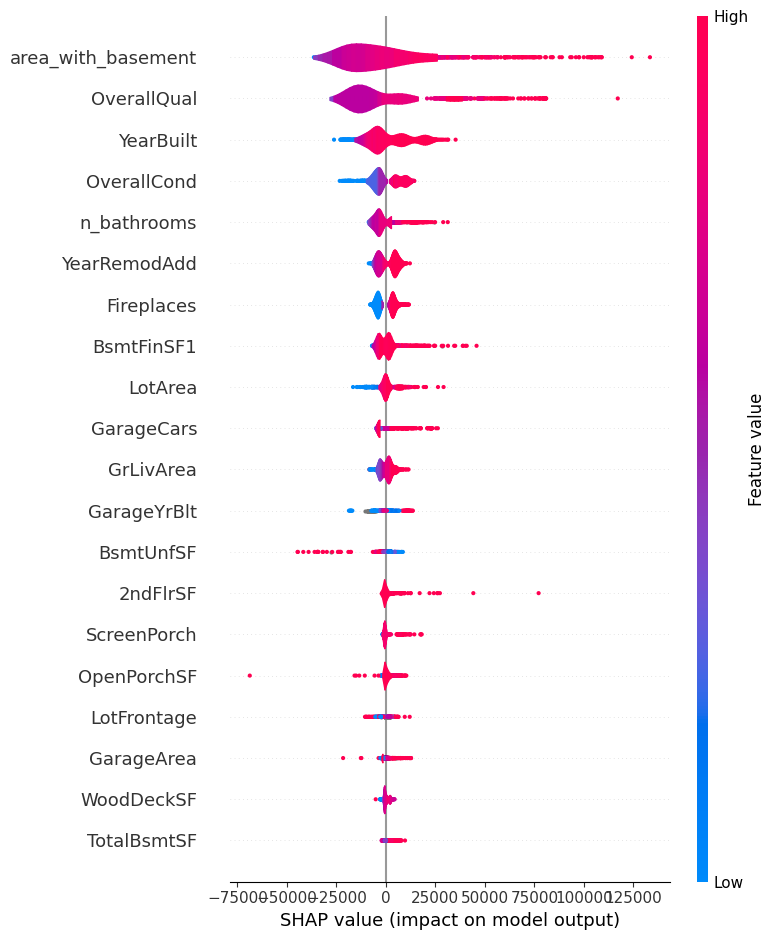

In [54]:
# violin plot
shap.summary_plot(shap_values, plot_type='violin')

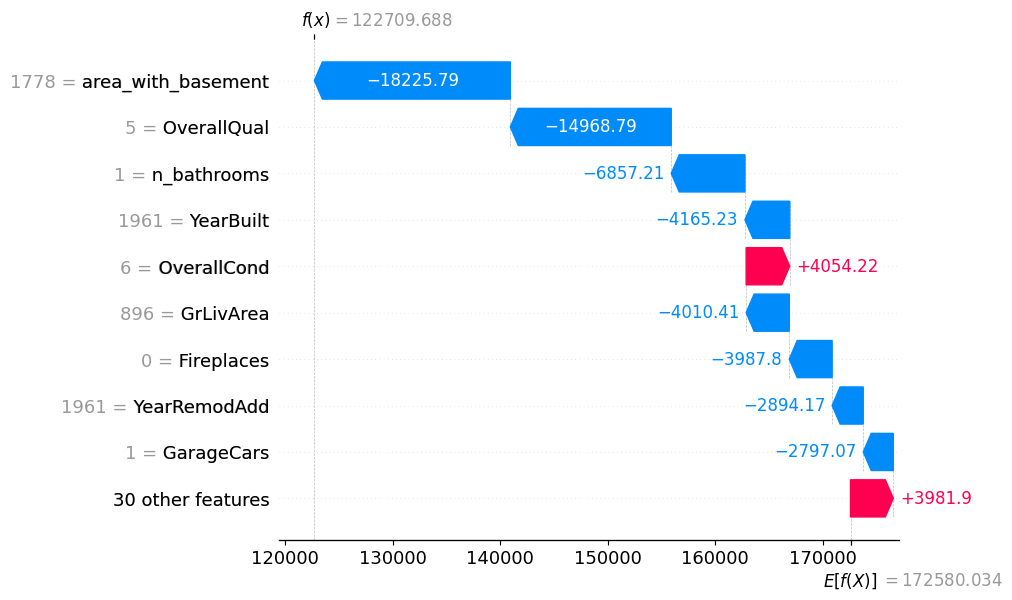

In [55]:
# waterfall plot
shap.plots.waterfall(shap_values[0])